In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_random_seed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

set_random_seed(0)
np.random.seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/split-garbage-dataset"

In [0]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
        rescale = 1./255
)
test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [5]:
img_shape = (224, 224, 3) # default values

train_batch_size = 256
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/valid',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [6]:
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# Freeze the layers except the last 3 layers
for layer in vgg.layers[:-3]:
    layer.trainable = False


In [0]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 30,416,902
Non-trainable params: 9,995,072
_________________________________________________________________


In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])

In [11]:
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('VGG16 Garbage Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=0,
    callbacks = [es, mc],)


Epoch 00001: val_acc improved from -inf to 0.51829, saving model to VGG16 Garbage Classifier.h5

Epoch 00002: val_acc improved from 0.51829 to 0.60366, saving model to VGG16 Garbage Classifier.h5

Epoch 00003: val_acc did not improve from 0.60366

Epoch 00004: val_acc improved from 0.60366 to 0.67073, saving model to VGG16 Garbage Classifier.h5

Epoch 00005: val_acc improved from 0.67073 to 0.72866, saving model to VGG16 Garbage Classifier.h5

Epoch 00006: val_acc did not improve from 0.72866

Epoch 00007: val_acc improved from 0.72866 to 0.77439, saving model to VGG16 Garbage Classifier.h5

Epoch 00008: val_acc did not improve from 0.77439

Epoch 00009: val_acc did not improve from 0.77439

Epoch 00010: val_acc did not improve from 0.77439

Epoch 00011: val_acc did not improve from 0.77439

Epoch 00012: val_acc improved from 0.77439 to 0.78963, saving model to VGG16 Garbage Classifier.h5

Epoch 00013: val_acc did not improve from 0.78963

Epoch 00014: val_acc did not improve from 0.7

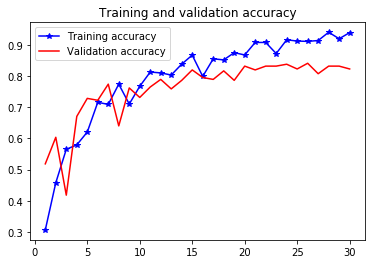

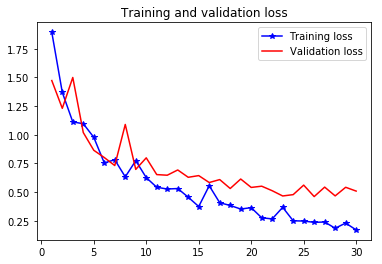

In [12]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
data = np.load('/content/drive/My Drive/test_data.npz')
x_test, y_test = data['x_test'], data['y_test']
y_pred = model.predict(x_test)

In [15]:
acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
print(acc)

0.839907192575406


In [0]:
confusion_matrix = np.zeros((6,6), dtype=np.uint8)
per_class_acc = np.zeros(6)
for i in range(y_test.shape[1]):
    idxs = np.argmax(y_test, axis=1)==i
    this_label = y_test[idxs]
    num_samples_per_class = np.count_nonzero(idxs)
    one_hot = tensorflow.one_hot(np.argmax(model.predict(x_test[idxs]), axis=1), depth=6).eval(session=tensorflow.Session())
    confusion_matrix[i] = np.sum(one_hot, axis=0)
    per_class_acc[i] = confusion_matrix[i,i]/num_samples_per_class

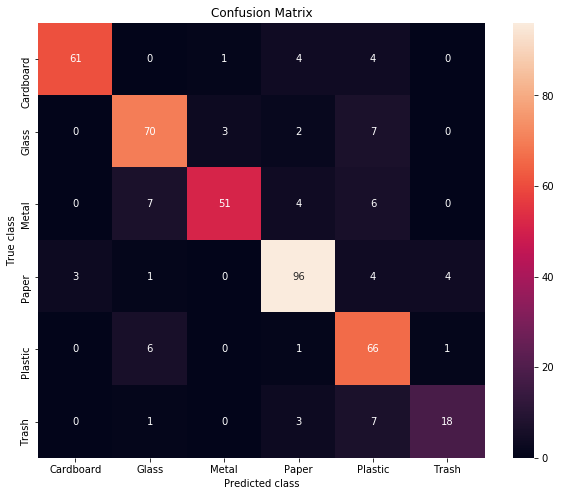

{'Cardboard': 0.8714285714285714,
 'Glass': 0.8536585365853658,
 'Metal': 0.75,
 'Paper': 0.8888888888888888,
 'Plastic': 0.8918918918918919,
 'Trash': 0.6206896551724138}

In [17]:
LABELS=['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

dict(zip(LABELS, per_class_acc))